# Method descriptions

* **centralized** finds global classifier using the centralized data
* Average local classifiers between neighbors
  * **avg-unweighted** all the edges have the same value
  * **avg-weighted** algorithm weights an edge as the *similarity* between the two nodes *times* the *number of instances* of the neighbor (normalized)
* **regularised** learns local classifiers keeping them similar to the neighbors' classifiers
* **local** learns independent local classifiers


In [21]:
# imports
from copy import deepcopy
import numpy as np

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_accuracy
from network import synthetic_graph
from related_works import colearning
from optimization import centralized_FW, async_regularized_local_FW, regularized_local_FW, local_FW, global_regularized_local_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# set graph of nodes with local personalized data
NB_ITER = 100
N = 100
D = 20
B = 100
NOISE_R = 0.05
random_state = 2017
MU = 0.01
BETA = 10

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=B, d=D+1, min_v=vmin, max_v=vmax)

In [23]:
results = {}

nodes_copy = deepcopy(nodes)
results["centralized"] = centralized_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

nodes_regularized = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_regularized, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)

# nodes_copy = deepcopy(nodes)
# results["async_regularized"] = async_regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)

local_nodes = deepcopy(nodes)
results["local"] = local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

nodes_copy = deepcopy(nodes)
results["global-reg"] = global_regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

# colearning results
results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

print("done")

done


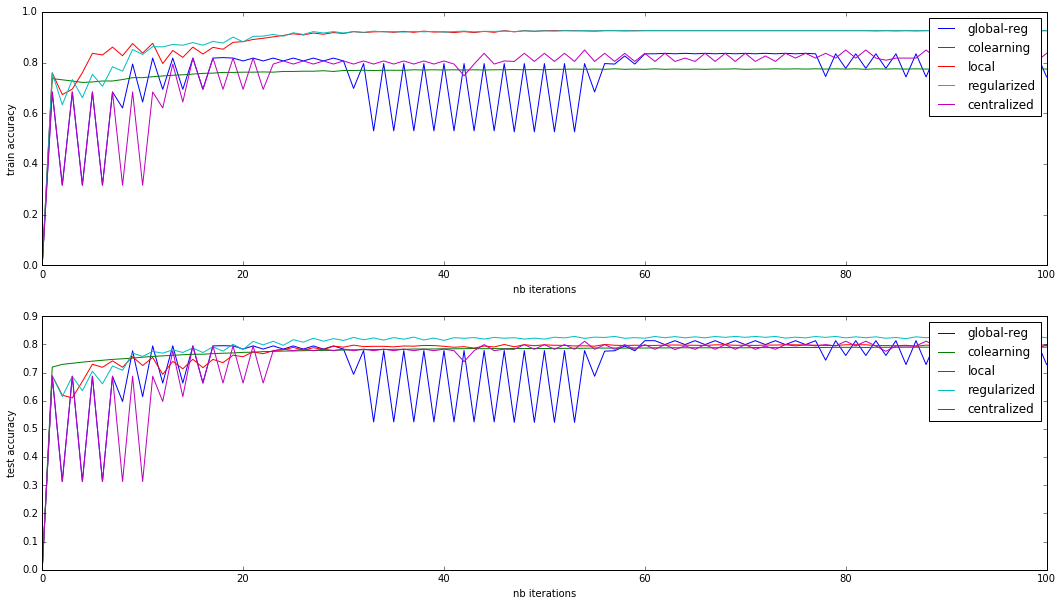

In [24]:
plt.figure(1, figsize=(18, 10))

plt.subplot(211)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))

plt.legend()

plt.subplot(212)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))

plt.legend()